In [1]:
import pandas as pd
import os
import numpy as np
from scipy.stats import mannwhitneyu
import seaborn as sns
from matplotlib import pyplot as plt
import re
import warnings
warnings.filterwarnings('ignore') #supresses warnings for now
#warnings.filterwarnings(action='once') #shows warnings once
from statannotations.Annotator import Annotator


dataFilePath = os.path.join(os.getcwd(),'Data')

kicsSVdf = pd.read_csv(os.path.join(dataFilePath,'kics_structural_variations.txt'), sep = '\t', header = 0)
#kicsTEdf = pd.read_csv(os.path.join(dataFilePath,'kics_transposable_elements.txt'), sep = '\t', header = 0)
lfsSVdf = pd.read_csv(os.path.join(dataFilePath,'lfs_structural_variations.txt'), sep = '\t', header = 0)
#lfsTEdf = pd.read_csv(os.path.join(dataFilePath,'lfs_transposable_elements.txt'), sep = '\t', header = 0)
lfsClinicdf = pd.read_csv(os.path.join(dataFilePath,'lfs_clinical_main.tsv'), sep = '\t', header = 0)
kicsClinicdf = pd.read_csv(os.path.join(dataFilePath,'kics_clinical_edited.csv'), encoding='latin-1')

In [2]:
"""
full filter and rare
"""

kicsSVdf = kicsSVdf.loc[(kicsSVdf['AnnotSV type'] == 'full')] #& (kicsSVdf['GD_AF'] < 0.01) & (kicsSVdf['GD_AF'] >=0)]
lfsSVdf = lfsSVdf.loc[(lfsSVdf['AnnotSV type'] == 'full')] #& (lfsSVdf['GD_AF'] < 0.01) & (lfsSVdf['GD_AF'] >=0)]

kicsSVdf['SV chrom'] = kicsSVdf['SV chrom'].astype(str)
lfsSVdf['SV chrom'] = lfsSVdf['SV chrom'].astype(str)

kicsSVdf['sample_id'] = kicsSVdf['sample_id'].astype(str)
lfsSVdf['sample_id'] = lfsSVdf['sample_id'].astype(str)

kicsSVdf['sample_id'] = kicsSVdf['sample_id'].str.replace(" ", "")
lfsSVdf['sample_id'] = lfsSVdf['sample_id'].str.replace(" ", "")

#kicsSVnum = kicsSVF['sample_id'].count()
#lfsSVnum = lfsSVF['sample_id'].count()


In [3]:
"""
Kics clinic df cleaning
"""
#listValSearch = ['291775', '298313', '315666', '320118', '18_1907']
listValSearch = ['63', '83', '156', '171', '219', '120', '141', '232']
# searched for kID of 63, 83, 156, 171, 219
# kID 120 141 and 232 do not have any matches...

kicsClinicdf['KiCS ID'] = kicsClinicdf['KiCS ID'].astype(str)
kicsClinicdf['KiCS ID'] = kicsClinicdf['KiCS ID'].str.replace(" ", "")

for i in listValSearch:
    kicsClinicdf.drop(kicsClinicdf[kicsClinicdf['KiCS ID']==i].index, inplace = True)

#these two lines are causing us to go from 140->90 ish samples    
kicsClinicdf.drop(kicsClinicdf.loc[kicsClinicdf['tissue_type']=='?'].index, inplace=True)
kicsClinicdf.drop(kicsClinicdf.loc[pd.isna(kicsClinicdf['lfs_cancer_type_diagnosis'])].index, inplace=True)


# # intial tissue types and diagnosis types
# kUniqueTissue = kicsClinicdf['tissue_type'].unique()
# kUniqueDiag = kicsClinicdf['lfs_cancer_type_diagnosis'].unique()

# print(kUniqueTissue)
# print(kUniqueDiag)

In [4]:
"""
lfs clinic df cleaning
"""
lfsClinicdf['sample'] = lfsClinicdf['sample'].astype(str)
lfsClinicdf['sample'] = lfsClinicdf['sample'].str.replace(" ", "")

for i in listValSearch:
    lfsClinicdf.drop(lfsClinicdf[lfsClinicdf['sample']==i].index, inplace = True)
    

#print(lfsClinicdf[lfsClinicdf['tissue_type']=='CNS']) #more than 1 patient
    
lfsClinicdf.drop(lfsClinicdf.loc[lfsClinicdf['tissue_type']=='?'].index, inplace=True)
lfsClinicdf.drop(lfsClinicdf.loc[pd.isna(lfsClinicdf['cancer_diagnosis'])].index, inplace=True)


#print(lfsClinicdf[lfsClinicdf['tissue_type']=='CNS']) #more than 1 patient

# lUniqueTissue = lfsClinicdf['tissue_type'].unique()
# lUniqueDiag = lfsClinicdf['cancer_diagnosis'].unique()

# print(lUniqueTissue)
# print(lUniqueDiag)

In [5]:
def BoxGraphMulti(df: pd.DataFrame, xCol, yCol, compCol, orderList):
    plt.rcParams["figure.figsize"] = [15, 15]
    ax = sns.boxplot(data=df, x=xCol, y=yCol, hue=compCol, medianprops={"linewidth": 4, 'color':'black'})
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
    
    #add statistical test here
    listPairing = []
    #pairings for multi correction
    for i in orderList:
        p1 = (i, 'kics')
        p2 = (i, 'lfs')
        p = (p1,p2)
        listPairing.append(p)
        
    annot = Annotator(ax, listPairing, data=df, x=xCol, y=yCol, hue=compCol)
    annot.configure(test='Mann-Whitney', text_format='star', loc='outside', verbose=2)
    annot.apply_and_annotate()

    plt.show()

    plt.show()

In [6]:
def BarGraphNormalized(label1: str, label2:str, df: pd.DataFrame, col1: str, col2: str,
                        xTitle: str, yTitle: str, divisor1: float, divisor2: float,
                        labels: list):
    #'kics', 'lfs', invdf, 'kchrom', 'lchrom', 'Chromosomes','Frequency','Graph2-INV',kicsSVnum, lfsSVnum

    title = label1 + " " + label2
    count1 = df[col1].value_counts()
    count2 = df[col2].value_counts()
    
    x_axis = np.arange(len(labels))
        
    for i in labels:
        if (not(i in count1)):
            add = pd.Series([0], index=[i])
            count1 = count1.append(add)
        if (not(i in count2)):
            add = pd.Series([0], index=[i])
            count2 = count2.append(add)
            
    
    plt.bar(x_axis - 0.2, [count1[a]/divisor1 for a in labels], 0.4, label = label1)
    plt.bar(x_axis + 0.2, [count2[a]/divisor2 for a in labels], 0.4, label = label2)

    plt.tick_params(labelrotation=45)
    plt.xticks(x_axis, labels)
    plt.xlabel(xTitle)
    plt.ylabel(yTitle)
    plt.title(title)
    plt.legend()
    plt.show()


In [7]:
"""
SV clean up
"""
def maxGDAFFilter(colName: str, df: pd.DataFrame)->pd.DataFrame:
    temp = df[colName].str.contains(pat=',')
    Index = list(np.where(temp == True)[0])
    temp = df[colName].iloc[Index]
    tempIndex = temp.index

    for i in tempIndex:
        tempList = temp[i].split(',')
        tempList = [float(a) for a in tempList]
        maxTemp = max(tempList)
        df[colName][i] = maxTemp

    df[colName] = df[colName].astype('float64')
    
    return df
    
kicsSVdf = maxGDAFFilter('GD_AF', kicsSVdf)
lfsSVdf = maxGDAFFilter('GD_AF', lfsSVdf)

listValSearch = ['291775', '298313', '315666', '320118', '18_1907']
# searched for kID of 63, 83, 156, 171, 219
# kID 120 141 and 232 do not have any matches...
#what would make this that much better is if it was a dict. Computationally less heavy?

for i in listValSearch: 
    kicsSVdf.drop(kicsSVdf[kicsSVdf['sample_id'].str.contains(i)==True].index, inplace = True)

In [8]:
"""
kics matching between SV and Clinical
"""

def kIdAbbv(clinicDf, svDf, clinicCol, svCol):
    
    clinicDf.drop(clinicDf[clinicDf[clinicCol]=='Not applicable'].index, inplace = True)
    
    svDf[svCol] = svDf[svCol].astype(str)
    clinicDf[clinicCol] = clinicDf[clinicCol].astype(str)
    svDf[svCol] =  svDf[svCol].str.replace(" ", "")
    clinicDf[clinicCol] = clinicDf[clinicCol].str.replace(" ", "")
    
    list1 = svDf[svCol].unique()
    list2 = clinicDf[clinicCol].unique()
    
    svDict = dict()
    clinicDict = dict()
    
    for i in range (len(list1)):
        tempList = re.findall('\d{3,}', list1[i])

        #if empty, take the second one
        if not tempList:
            tempList = re.findall('\d+', list1[i])
            svDict[list1[i]] = tempList[1]

        #if not empty 
        else:
            svDict[list1[i]] = tempList[0]


    for i in range (len(list2)):    
        tempList = re.findall('\d{3,}', list2[i])
    
        #if empty, take the second one
        if not tempList:
            tempList = re.findall('\d+', list2[i])
            clinicDict[list2[i]] = tempList[1]

        #if not empty 
        else:
            clinicDict[list2[i]] = tempList[0]
    

    clinicDf['abbv_id'] = clinicDf[clinicCol].map(clinicDict)
    svDf['abbv_id'] = svDf[svCol].map(svDict)
    
    print(len(svDf[svCol].unique()))
#     print(svDf[svCol].unique())
    
    df = pd.merge(svDf[[svCol,'SV type','abbv_id']],                   
                     clinicDf[[clinicCol, 'tumour_class','tissue_type','lfs_cancer_type_diagnosis', 'abbv_id']],
                     left_on = 'abbv_id', 
                     right_on = 'abbv_id', 
                     how='inner')

    return df

In [9]:
bigKDf = kIdAbbv(kicsClinicdf, kicsSVdf, 'CCP germline', 'sample_id',)
print(len(bigKDf['abbv_id'].unique()))
# print(bigKDf['sample_id'].unique())
# print(len(kicsSVdf['sample_id'].unique()))
# print(len(kicsClinicdf['CCP germline'].unique()))
#prints out how many we had before the id matching and how many we have left after the id matching

187
93


In [10]:
print(bigKDf)

      sample_id SV type abbv_id CCP germline       tumour_class tissue_type  \
0        313703     DEL  313703       313703         CNS TUMORS         CNS   
1        313703     DEL  313703       313703         CNS TUMORS         CNS   
2        313703     DEL  313703       313703         CNS TUMORS         CNS   
3        313703     DEL  313703       313703         CNS TUMORS         CNS   
4        313703     DEL  313703       313703         CNS TUMORS         CNS   
...         ...     ...     ...          ...                ...         ...   
27585    292600     INV  292600       292600  LEUKEMIA/LYMPHOMA       Blood   
27586    292600     DEL  292600       292600  LEUKEMIA/LYMPHOMA       Blood   
27587    292600     DEL  292600       292600  LEUKEMIA/LYMPHOMA       Blood   
27588    292600     DEL  292600       292600  LEUKEMIA/LYMPHOMA       Blood   
27589    292600     DEL  292600       292600  LEUKEMIA/LYMPHOMA       Blood   

      lfs_cancer_type_diagnosis  
0                

In [11]:
"""Filter the ? and the nan"""
#print(bigKDf['tissue_type'].unique())
bigKDf.drop(bigKDf.loc[bigKDf['tissue_type']=='?'].index, inplace=True)

#bigKDfDiag.drop(bigKDf.loc[pd.isna(bigKDf['lfs_cancer_type_diagnosis'])].index, inplace=True)
print(len(bigKDf['abbv_id'].unique()))
#print(kicsClinicdf['tissue_type'].value_counts())

93


In [12]:
lfsSVdf['sample_id'] = lfsSVdf['sample_id'].astype(str)
lfsClinicdf['sample'] = lfsClinicdf['sample'].astype(str)

In [13]:
print(len(lfsSVdf['sample_id'].unique())) #only 65 to begin with D:
print(lfsSVdf['sample_id'].unique())

print(len(lfsClinicdf['sample'].unique()))

65
['4257' 'SJACT008_G' '808' '2085' '1087' '1092' '3805' '3136A' '4033'
 '2447' '353' '3806' '4854' '1478' '2262' '4028' '2957' '3688' '93' '1357'
 '2565' '4329' '4535_S1' '3298A' '2349' '2446' '3473' '5567' '3273' '3885'
 '3432' '1843' '3763' '3503' 'PD13489b' '2463' '2760A' '3643' 'SJACT001_G'
 '4227' '5537' '3367' 'SJACT002_G' '2815' '5536' '3634' '1476'
 'SJACT005_G' '3425' '3365' '2413' 'SJACT007_G' '3356' '3361' '3687_2'
 '3332' '94' '1355' '2784' '2465' '3319' 'PD7195b' '3334' '352' '2765']
460


In [14]:
"""
Can directly map the two
Apply on Filtered Prelim Graphs
"""

bigLDf = pd.merge(lfsSVdf[['sample_id','SV chrom','GD_AF', 'SV type']],
                 lfsClinicdf[['sample','tissue_type','cancer_diagnosis']],
                 left_on = 'sample_id',
                 right_on = 'sample',
                 how='inner')

In [15]:
"""
Difference between the unique tissues and unique diagnosis in kics vs lfs
"""

tissueDiff = list(set(bigLDf['tissue_type']).symmetric_difference(set(bigKDf['tissue_type'])))
diagDiff = list(set(bigLDf['cancer_diagnosis']).symmetric_difference(set(bigKDf['lfs_cancer_type_diagnosis'])))

print(tissueDiff)
print(diagDiff)

['Unaffected', 'Other', 'Thyroid', 'Sarcoma', 'Ovaries', 'US']
['AL', 'AMKL', 'LMS', 'Other', 'CSA', 'Meningioma', 'Sarcoma', 'MFS', 'Undifferentiated sarcoma', 'PNET', 'MFH', 'AML', 'Unaffected', 'ALL', 'T-NHL', 'AA', 'Thyroid', 'B-ALL', 'CPC', 'MPAL', 'T-LL', 'Ovaries', 'High Grade Sarcoma']


In [16]:
"""
Drop the rows that are in the diff
"""

####YOU DROPPED TOO MANY, Don't drop any
#bigLDf.drop(bigLDf[bigLDf['tissue_type'].isin(tissueDiff)].index, inplace = True)
#bigKDf.drop(bigKDf[bigKDf['tissue_type'].isin(tissueDiff)].index, inplace = True)

#bigLDf.drop(bigLDf[bigLDf['cancer_diagnosis'].isin(diagDiff)].index, inplace = True)
#bigKDf.drop(bigKDf[bigKDf['lfs_cancer_type_diagnosis'].isin(diagDiff)].index, inplace = True)

#print(bigKDf.columns)
#print(bigLDf.columns)


kicsTissue = pd.DataFrame(data = {'tissue_type':bigKDf['tissue_type'], 'id':bigKDf['sample_id']})
kicsT = kicsTissue

lfsTissue = pd.DataFrame(data = {'tissue_type':bigLDf['tissue_type'], 'id':bigLDf['sample']})
lfsT = lfsTissue

groupedTissue = pd.DataFrame(data={'ktissue':kicsTissue['tissue_type'], 'ltissue':lfsTissue['tissue_type']})

lfsDiag = pd.DataFrame(data = {'diag':bigLDf['cancer_diagnosis'], 'id':bigLDf['sample']})
lfsD = lfsDiag
kicsDiag = pd.DataFrame(data = {'diag':bigKDf['lfs_cancer_type_diagnosis'], 'id':bigKDf['sample_id']})
kicsD = kicsDiag

groupedDiag = pd.DataFrame(data={'kdiag':kicsDiag['diag'],'ldiag': lfsDiag['diag']})

kicsTidList = kicsDiag['id'].unique()
lfsTidList = lfsDiag['id'].unique()
kicsDiagList = kicsDiag['diag'].unique()

kicsIdList = kicsTissue['id'].unique()
kicsTissueList = kicsTissue['tissue_type'].unique()
lfsIdList = lfsTissue['id'].unique()

print(kicsTissue['tissue_type'].unique())
print(lfsTissue['tissue_type'].unique())


['CNS' 'Soft Tissue' 'Blood' 'Bone' 'Other' 'US' 'Thyroid' 'Breast'
 'Colon' 'Adrenal' 'Ovaries']
['Breast' 'Adrenal' 'Soft Tissue' 'Unaffected' 'Blood' 'Bone' 'Sarcoma'
 'CNS' 'Colon']


# Diagnosis Type

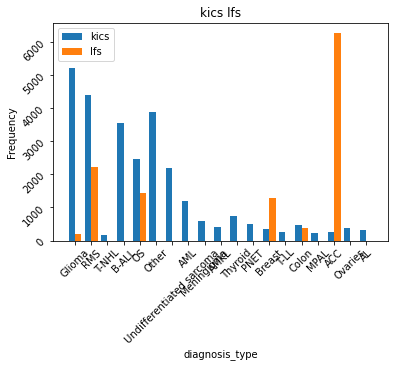

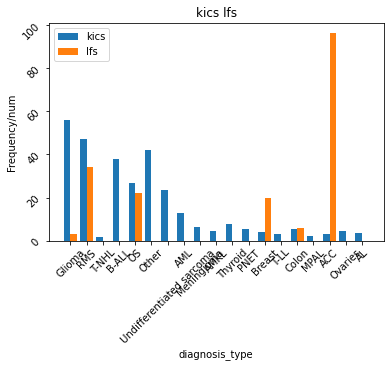

In [17]:
BarGraphNormalized('kics', 'lfs', groupedDiag, 'kdiag', 'ldiag', 'diagnosis_type', 'Frequency', 1.0,1.0, kicsDiagList)
    
BarGraphNormalized('kics', 'lfs', groupedDiag, 'kdiag', 'ldiag', 'diagnosis_type','Frequency/num',
                   len(kicsTidList), len(lfsTidList), kicsDiagList)

# Tissue Type

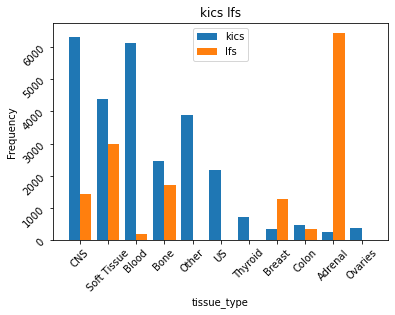

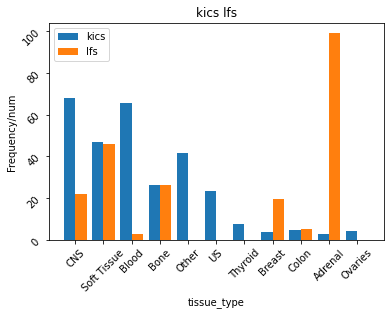

In [18]:
BarGraphNormalized('kics', 'lfs', groupedTissue, 'ktissue', 'ltissue', 'tissue_type','Frequency',
                   1.0,1.0, kicsTissueList)

BarGraphNormalized('kics', 'lfs', groupedTissue, 'ktissue', 'ltissue', 'tissue_type', 'Frequency/num',
                  len(kicsIdList), len(lfsIdList), kicsTissueList)

In [19]:
kDel = bigKDf.loc[bigKDf['SV type'] == 'DEL']
kDup = bigKDf.loc[bigKDf['SV type'] == 'DUP']
kInv = bigKDf.loc[bigKDf['SV type'] == 'INV']

lDel = bigLDf.loc[bigLDf['SV type'] == 'DEL']
lDup = bigLDf.loc[bigLDf['SV type'] == 'DUP']
lInv = bigLDf.loc[bigLDf['SV type'] == 'INV']

#print(kDel.head(30))

In [20]:
def graphSVTissue(kdf, ldf, listTissue):
    kdf = kdf.drop(['sample_id', 'SV type'], axis=1)
    kdf = kdf.groupby(['abbv_id']).value_counts()
    kdf = kdf.to_frame().reset_index()

    kdf.rename(columns = {0:'freq'}, inplace = True)
    kdf = pd.melt(kdf, id_vars=['tissue_type'], value_vars=['freq'])
    kdf['dataset'] = 'kics'

    ldf = ldf.drop(['SV chrom', 'GD_AF',
                        'SV type'], axis=1)
    ldf = ldf.groupby(['sample_id']).value_counts()
    ldf = ldf.to_frame().reset_index()
    ldf.rename(columns = {0:'freq'}, inplace = True)

    ldf = pd.melt(ldf, id_vars=['tissue_type'], value_vars=['freq'])
    ldf['dataset'] = 'lfs'

    mergedDf = pd.concat([ldf, kdf])
    
    BoxGraphMulti(mergedDf,'tissue_type', 'value', 'dataset', listTissue) 

## DEL

['CNS' 'Soft Tissue' 'Blood' 'Bone' 'Other' 'US' 'Thyroid' 'Breast'
 'Colon' 'Adrenal' 'Ovaries']
['Breast' 'Adrenal' 'Soft Tissue' 'Unaffected' 'Blood' 'Bone' 'Sarcoma'
 'CNS' 'Colon']


ValueError: `x` and `y` must be of nonzero size.

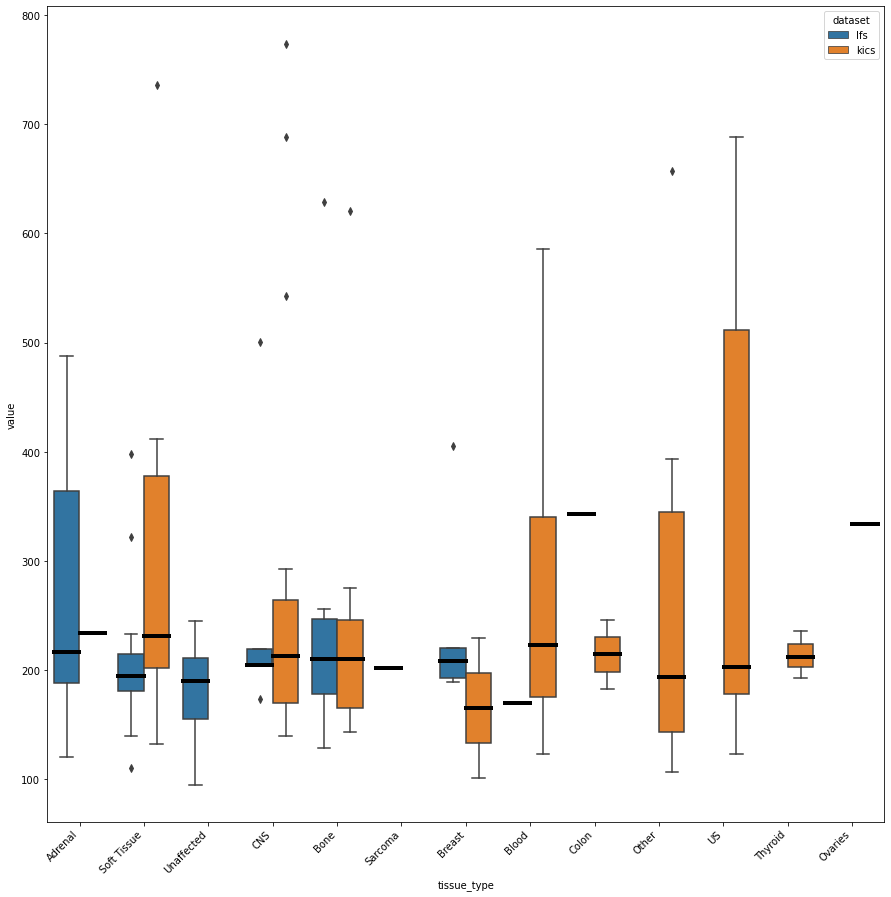

In [21]:
print(kDel['tissue_type'].unique())
print(lDel['tissue_type'].unique())
graphSVTissue(kDel, lDel, kicsTissueList)

## DUP

In [ ]:
print(kicsTissueList)
graphSVTissue(kDup, lDup, kicsTissueList)


## INV

In [ ]:
graphSVTissue(kInv, lInv, kicsTissueList)

In [ ]:
"""
rare variants first
LFS vs Kics for Diagnosis type
LFS vs unaffected
"""

